In [133]:
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal
import pymc3 as pm
from patsy import dmatrix

import warnings
# To remove irritating deprecation warning for Arviz
warnings.filterwarnings('ignore')

az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

# Gaussian Height Model Example

### Get Height Data

In [2]:
data_path = '/home/jonathan/Projects/LearningReferences/resources/Rethinking_2/Data'
height_df = pd.read_csv(data_path + '/Howell1.csv', sep=';', header=0)

adults_df= height_df.loc[height_df.age >= 18]

In [3]:
az.summary(adults_df.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
height,154.597,7.742,139.700,167.005
weight,44.990,6.457,34.189,57.068
age,41.138,15.968,18.000,69.000
male,0.469,0.500,0.000,1.000


### Modeling Process and Height Model Definition

Process:   
1. Identify variables: observed data and unobserved parameters
2. Define each variable in terms of other variables or distributions
3. The combination of variables and distributions defines a *joint generative model* 

Height model:   
$Pr(\mu, \sigma \mid h) = \dfrac{\prod_i Normal(h_i \mid \mu, \sigma)Normal(\mu \mid 178, 20)Uniform(\sigma, 0, 50)}{\int\int\prod_i Normal(h_i \mid \mu, \sigma)Normal(\mu \mid 178, 20)Uniform(\sigma, 0, 50) \; d\mu d\sigma }$   
Observed (data likelihood):   
   $\;\;h_i \sim Normal(\mu, \sigma)$   
Parameters (priors):   
    $\;\;\mu \sim Normal(178, 20)$   
    $\;\;\sigma \sim Uniform(0, 50)$

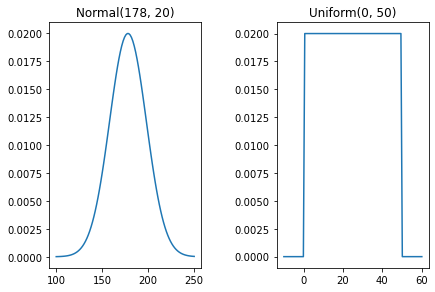

In [4]:
# Priors for mu and sigma
xn = np.linspace(100, 250, 100)
xu = np.linspace(-10, 60, 100)
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()
axs[0].plot(xn, stats.norm.pdf(xn, 178, 20))
axs[0].set_title('Normal(178, 20)')
axs[1].plot(xu, stats.uniform.pdf(xu, 0, 50))
axs[1].set_title('Uniform(0, 50)')
plt.subplots_adjust(wspace = .5)
plt.show()

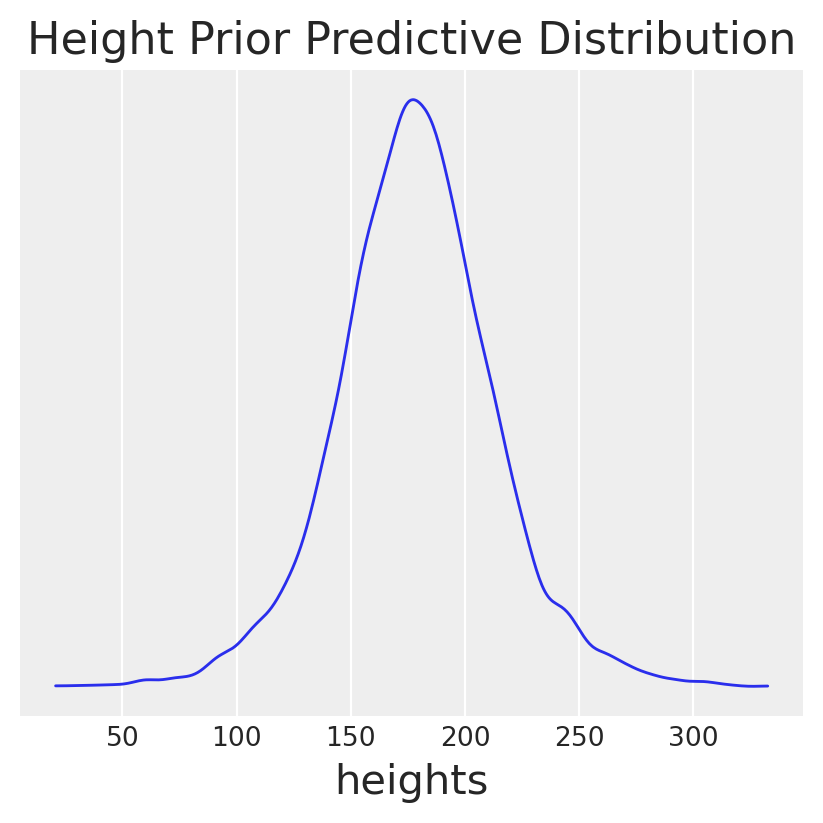

In [178]:
# Prior Predictive Simulation to verify reasonableness of height prior 
#  - a distribution of relative plausibilities of different heights(before seeing data)
n_samples = 10000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h, figsize=(4, 4))
plt.xlabel("heights")
plt.yticks([])
plt.title('Height Prior Predictive Distribution');

In [6]:
# Posterior Distribution by Quadratic Approximation - Not clear how to use this to sample . . . 

with pm.Model() as height_normal:
    mu_h = pm.Normal("mu_h", mu=178, sigma=20, testval=adults_df.height.mean())
    sigma_h = pm.Uniform("sigma_h", lower=0, upper=50, testval=adults_df.height.std())
    h = pm.Normal("h", mu=mu_h, sigma=sigma_h, observed=adults_df.height)
    mean_height = pm.find_MAP()
    std_height = np.sqrt(1/pm.find_hessian(mean_height, vars=[mu_h, sigma_h]))
    
print(f'mean mu_height {mean_height["mu_h"].item()}, mean sigma_height {mean_height["sigma_h"].item()}')
print(f'std mu_height {std_height[0, 0]}, std sima_height {std_height[0, 0]}')


mean mu_height 154.60702357669257, mean sigma_height 7.731333068652374
std mu_height 0.41199399498711065, std sima_height 0.41199399498711065


In [168]:
# Using Sampler for Posterior Distribution
with pm.Model() as height_normal:
    mu_h = pm.Normal("mu_h", mu=178, sigma=20, testval=adults_df.height.mean())
    sigma_h = pm.Uniform("sigma_h", lower=0, upper=50, testval=adults_df.height.std())
    h = pm.Normal("h", mu=mu_h, sigma=sigma_h, observed=adults_df.height)
    h_trace = pm.sample(1000, tune=1000)
    prior_pred = pm.sample_prior_predictive(samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_h, mu_h]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [169]:
az.summary(h_trace, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
mu_h,154.619,0.417,153.949,155.283
sigma_h,7.775,0.294,7.295,8.217


In [170]:
prior_pred.keys()

dict_keys(['h', 'sigma_h_interval__', 'sigma_h', 'mu_h'])

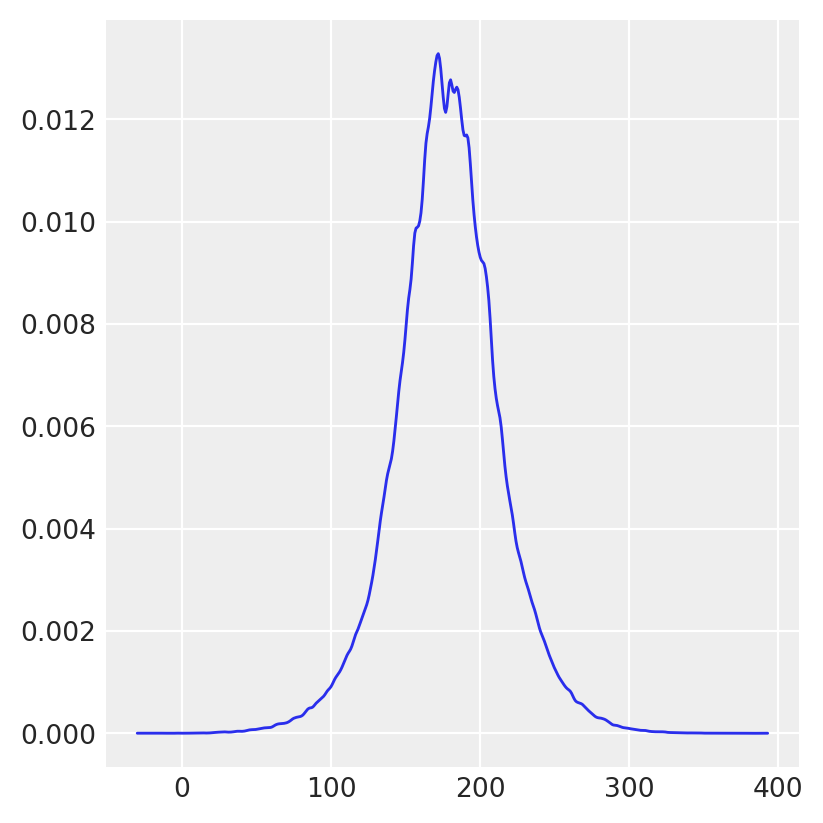

In [179]:
az.plot_kde(prior_pred['h'], figsize=(4, 4));

### Summarizing and Predicting with Posterior

With the posterior distribution you can calculate various summaries:
* Intervals of defined boundaries - e.g. add up posterior/sample where p < .5, i.e. how much of the posterior is below 50%
* Intervals of defined probability mass - credible interval, e.g. boundaries of the lower 80% posterior probability
  * Percentile Intervals - equal weights both tails, good for symmetric-like distributions
  * Highest Posterior Density Interval - Narrowest interval containing a specified probability mass
* Point estimates - e.g. Maximum A Posterior estimate, mean, median, 

In [11]:
# Interval of defined boundary e.g. 
h_df = pm.trace_to_dataframe(h_trace)
val = 100*(h_df.loc[h_df.mu_h < 154, 'mu_h']).count()/h_df.shape[0]
print(f'Percent where height below 154: {val}%')

Percent where height below 154: 7.9%


In [15]:
# Interval of defined probability mass - PI
print(f'10%-90% PI {np.percentile(h_df.mu_h, [10, 90])}')

# HDPI
print(f'95% HDPI {az.hdi(h_df.mu_h.values, hdi_prob=0.95)}')

10%-90% PI [154.05959107 155.11052563]
95% HDPI [153.74875835 155.36896334]


In [23]:
# Point Estimate
stats.mode(np.round(h_df.mu_h, 3))

ModeResult(mode=array([154.551]), count=array([9]))

Simulation of the model's implied observations
* Bayesian models are generative
  * Given parameters, the likelihood defines a distribution of possible observations that can be sampled from to simulate observations
  * Simulate observations using the samples from the posterior distrubion to propagate uncertainty $\rightarrow $ called the *Posterior Predictive Distribution*
* Useful in comparing (using various metrics and aspects) against the observed data to verify the model
* **Look in PYMC3 documentation on Prior and Posterior Predictive Checks** 

In [45]:
ppc = stats.norm.rvs(loc=h_df.mu_h.values, scale=h_df.sigma_h, size=h_df.shape[0])

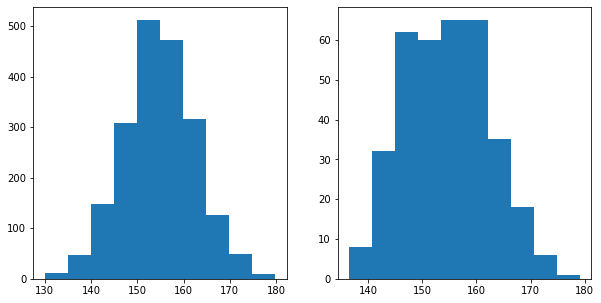

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].hist(ppc)
axs[1].hist(adults_df.height);

## Linear Prediction 

* Processing of relating a predictor variable(s) with outcome variable
* Makes the parameter for the mean of a Gausian distribution, $\mu$, into a linear function of the predictor variable and other, new parameters
  * Some of the parameters represent strength of association between mean outcome $\mu$ and the value of some other variable
  * Posterior distribution provides relative plausibilities of the different possible strengths of association $\rightarrow$ Considers all lines that relate one variable to the other and rank the lines by plausibility given these data
  
### One Predictor Variable Example: Weight as Predictor for Height
   
Observed (data likelihood):   
   $\;\;h_i \sim Normal(\mu_i, \sigma)$   
Linear Model:   
   $\;\;\mu_i = \alpha + \beta(x_i - \bar{x})$, where $x$ is the weight values vector   
Parameters (priors):   
    $\;\;\alpha \sim Normal(178, 20)$   
    $\;\;\beta \sim Normal(0, 10)$   
    $\;\;\sigma \sim Uniform(0, 50)$     


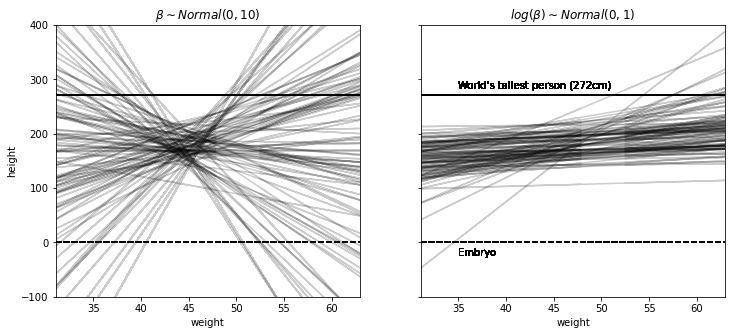

In [59]:
# Perform prior predictive simulation to understand what our prior implies. 
# Here it is seen original model of using Beta as Normal does not make sense and a lognormal distribution makes more sense
np.random.seed(2971)
N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

_, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
xbar = adults_df.weight.mean()
x = adults_df.weight.values
for i in range(N):
    ax[0].plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(adults_df.weight.min(), adults_df.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")
    ax[0].set_title(r'$\beta \sim Normal(0,10)$')

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(adults_df.weight.min(), adults_df.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].set_title(r'$log(\beta) \sim Normal(0,1)$')
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

Adjusting the model to have:    
$\beta \sim Log-Normal(0,1)$

In [98]:
xbar = adults_df.weight.mean()
with pm.Model() as lin_height_model:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta*(adults_df.weight - xbar)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=adults_df.height)
    hlin_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [61]:
# Should look at numerical output of posterior
az.summary(hlin_trace, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,154.609,0.277,154.078,155.111
beta,0.904,0.044,0.820,0.984
sigma,5.100,0.198,4.733,5.460


In [62]:
hlin_df = pm.trace_to_dataframe(hlin_trace)
hlin_df.cov().round(3)

,alpha,beta,sigma
alpha,0.077,-0.000,-0.001
beta,-0.000,0.002,-0.000
sigma,-0.001,-0.000,0.039


In [87]:
'''
Create regression interval and contour
Same idea as plotting many lines for alpha/beta values over data. Instead, for each weight value value compute mu distribution 
and compute mean and hpd
'''

weight_seq = np.arange(25, 71)
hlin_trace_thin = hlin_trace[::10]
mu_pred = np.zeros((len(weight_seq), len(hlin_trace_thin) * hlin_trace.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = hlin_trace_thin["alpha"] + hlin_trace_thin["beta"] * (w - adults_df.weight.mean())
    
mu_mean = mu_pred.mean(1)
mu_hpd = az.hpd(mu_pred.T)

In [104]:
height_pred = pm.sample_posterior_predictive(hlin_trace, 500, lin_height_model)

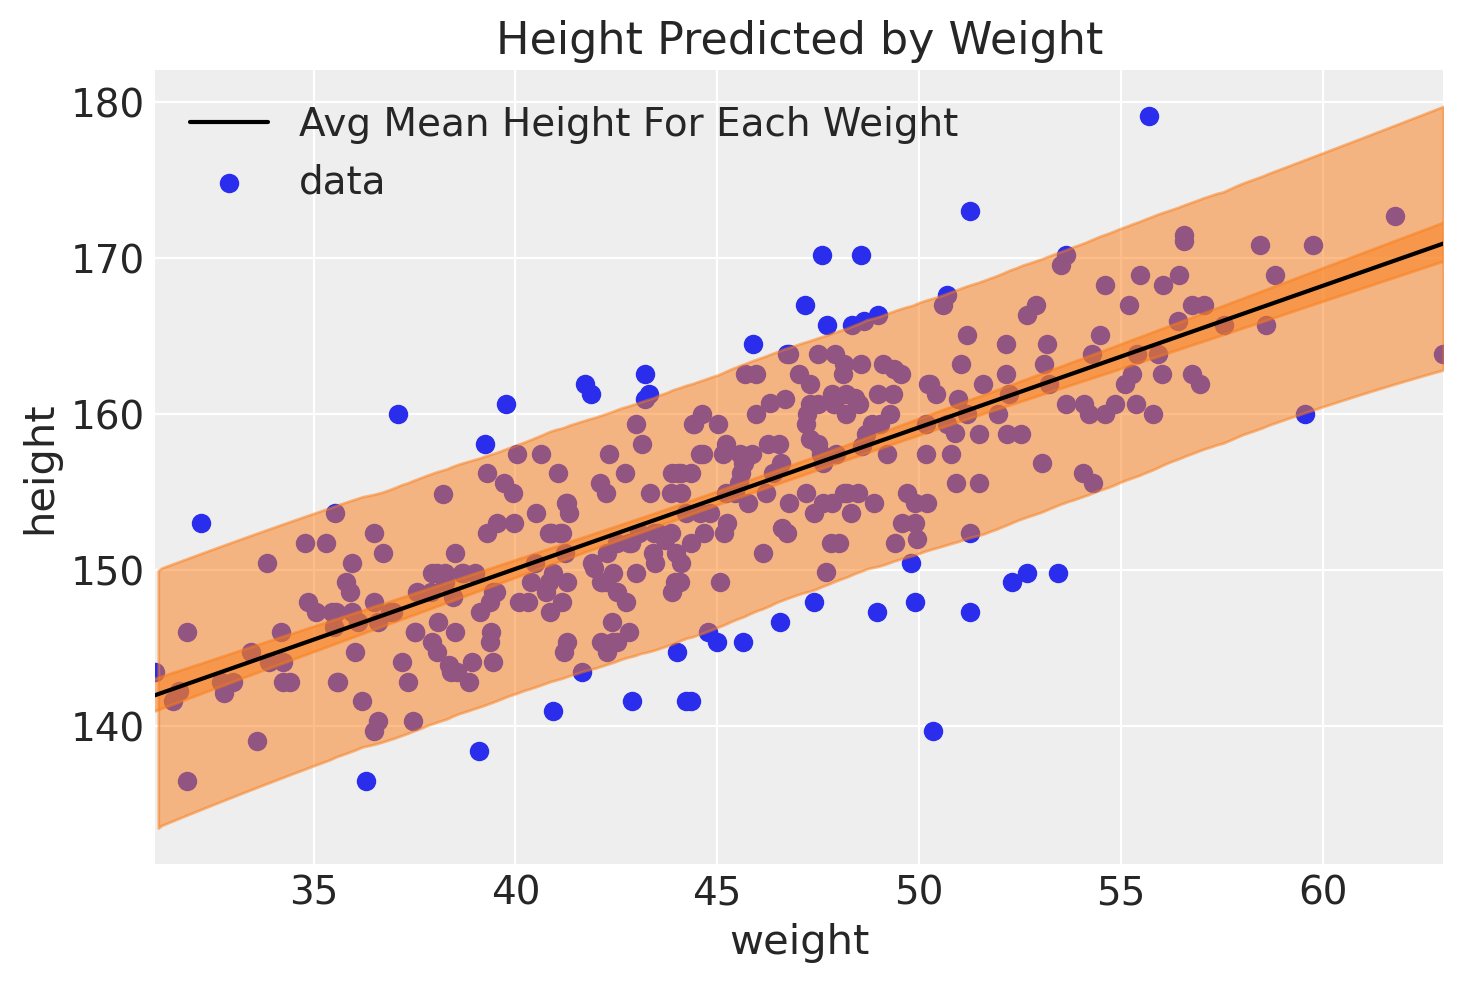

In [127]:
plt.scatter(adults_df.weight, adults_df.height, label='data') # plot observations
plt.plot(weight_seq, mu_mean, "k", label='Avg Mean Height For Each Weight') # plot average of mean height distribution per weight
ax = plt.gca()
az.plot_hpd(weight_seq, mu_pred.T, ax=ax) # Plot HDI of mean height
az.plot_hpd(adults_df.weight, height_pred["height"], ax=ax) # Plot HDI for height prediction
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(adults_df.weight.min(), adults_df.weight.max())
plt.legend()
plt.title('Height Predicted by Weight');

## Polynomial Regression

Uses powers of variables to act as additional predictors. A challenge is relating the output to the physical world meaning of the original variables.   
   
Example uses a $2^{nd}$ power linear model but we can use any power(just not clear if one should).   
Observed (data likelihood):   
   $\;\;h_i \sim Normal(\mu_i, \sigma)$   
Linear Model:   
   $\;\;\mu_i = \alpha + \beta_1\hat{x}_i + \beta_2\hat{x}^2_i$, where $\hat{x}$ is the standardized (subtract $\mu$ and divide $\sigma$)weight values vector   
Parameters (priors):   
    $\;\;\alpha \sim Normal(178, 20)$   
    $\;\;\beta_1 \sim Log-Normal(0, 1)$   
    $\;\;\beta_2 \sim Normal(0, 1)$   
    $\;\;\sigma \sim Uniform(0, 50)$   



In [128]:
height_df["weight_std"] = (height_df.weight - height_df.weight.mean()) / height_df.weight.std()
height_df["weight_std2"] = height_df.weight_std ** 2

with pm.Model() as poly_height_model:
    a = pm.Normal("a", mu=178, sd=20)
    b1 = pm.Lognormal("b1", mu=0, sd=1)
    b2 = pm.Normal("b2", mu=0, sd=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b1 * height_df.weight_std + b2 * height_df.weight_std2)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=height_df.height)
    poly_height_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


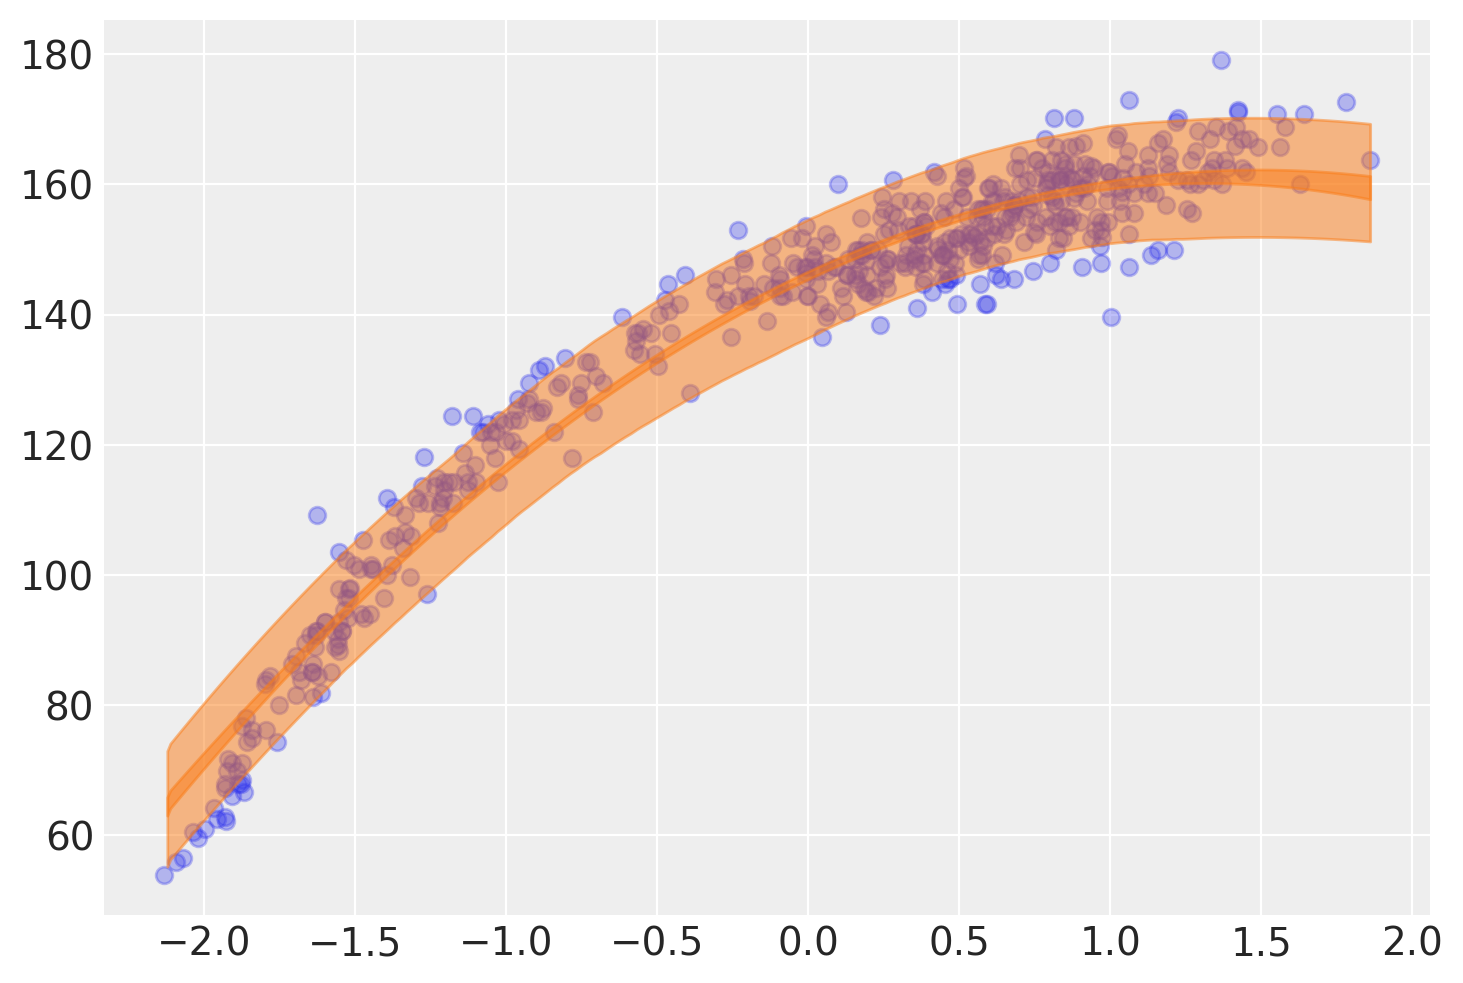

In [183]:
mu_pred = poly_height_trace["mu"]
height_pred = pm.sample_posterior_predictive(poly_height_trace, 200, poly_height_model)

plt.scatter(height_df.weight_std, height_df.height, c="C0", alpha=0.3)
ax = plt.gca()
az.plot_hpd(height_df.weight_std, mu_pred, ax=ax)
az.plot_hpd(height_df.weight_std, height_pred["height"], ax=ax);

## Spline 

This example uses a basis spline, a B-Spline, which uses basis functions to fit the data. Divides the full range of the predictor variable into parts and assign a parameter to each part that act as synthetic predictor variables. Range is divided into parts by pivot points called *knots*. These parameters are linearily combined with weights, that are learned for each parameter, which "turn on" and "turn off" basis functions over a range of the original predictor variable.   
$$\mu_i = \alpha + w_1\beta_{i,1} + w_2\beta_{i, 2} + w_3\beta_{i, 3} + \cdots$$   
   
Must determine:
* How many knots and where to put them
* Polynomial degree - the degree determines how basis functions interact/combine. For degree n, n+1 basis functions combine at each point. 
* Fit model to determine weights

In [155]:
knots = 15
knot_list = np.quantile(height_df.weight, np.linspace(0, 1, knots))

In [156]:
basis_fxns = dmatrix("bs(weight, knots=knots, degree=3, include_intercept=True) - 1", 
                     {"weight": height_df.weight.values, "knots": knot_list[1:-1]}
                    )

In [157]:
with pm.Model() as bspline_model:
    a = pm.Normal("a", mu=178, sd=100)
    w = pm.Normal("w", mu=0, sd=10, shape=basis_fxns.shape[1])
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(basis_fxns, order='F'), w.T))
    height = pm.Normal("height", mu=mu, sd=sigma, observed=height_df.height)
    bspline_height_trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


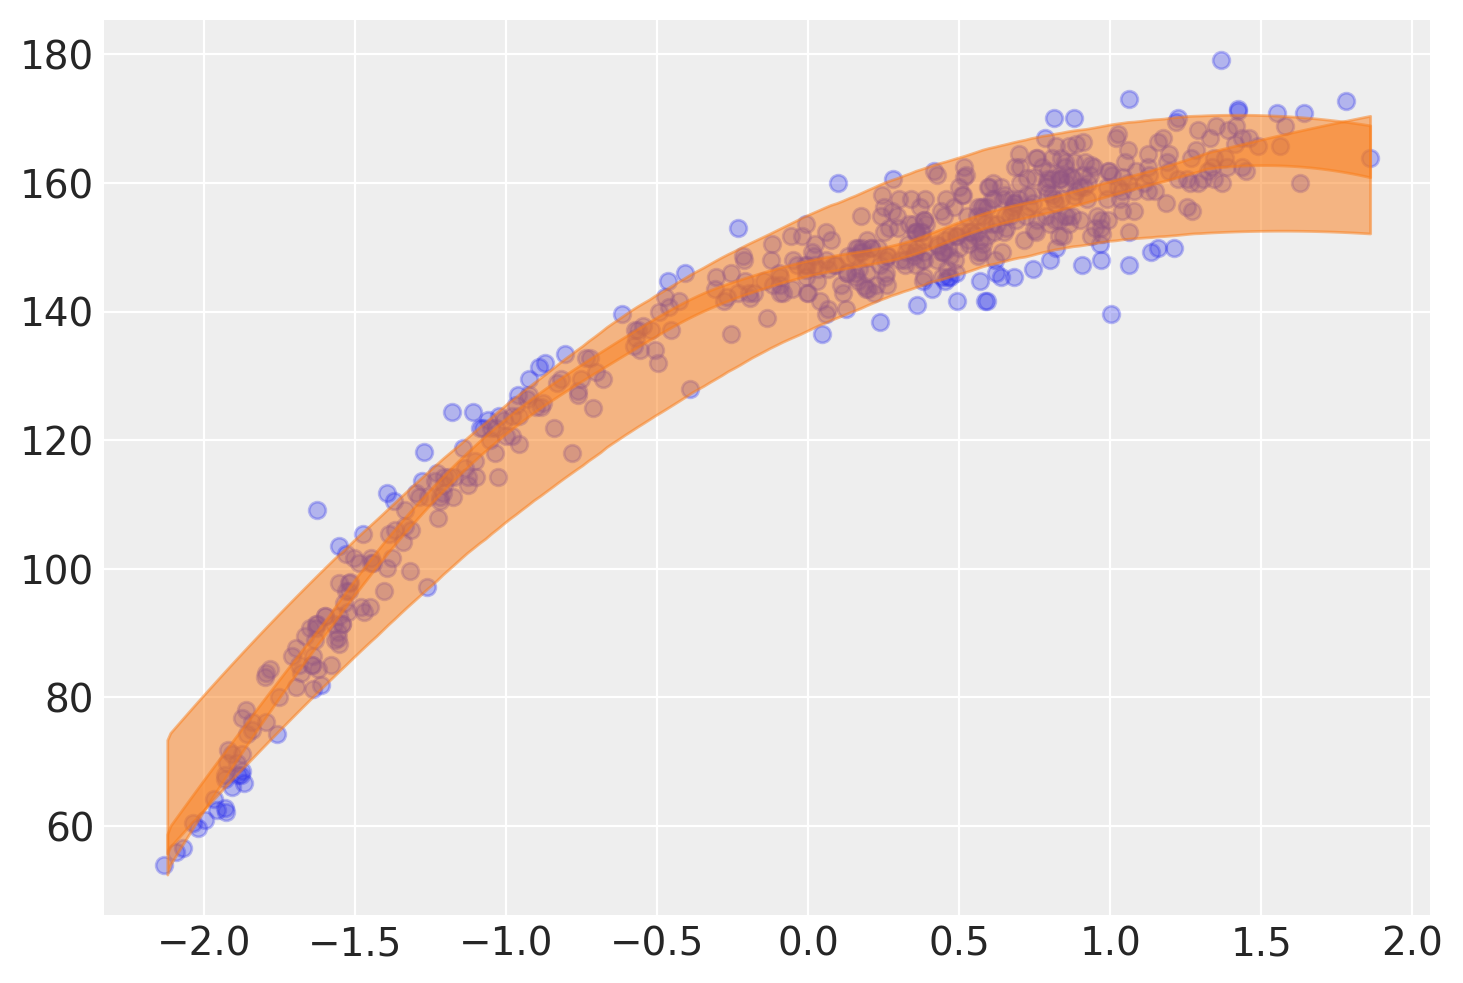

In [180]:
mu_pred = bspline_height_trace["mu"]
height_pred = pm.sample_posterior_predictive(poly_height_trace, 200, poly_height_model)

plt.scatter(height_df.weight_std, height_df.height, c="C0", alpha=0.3)
ax = plt.gca()
az.plot_hpd(height_df.weight_std, mu_pred, ax=ax)
az.plot_hpd(height_df.weight_std, height_pred["height"], ax=ax);

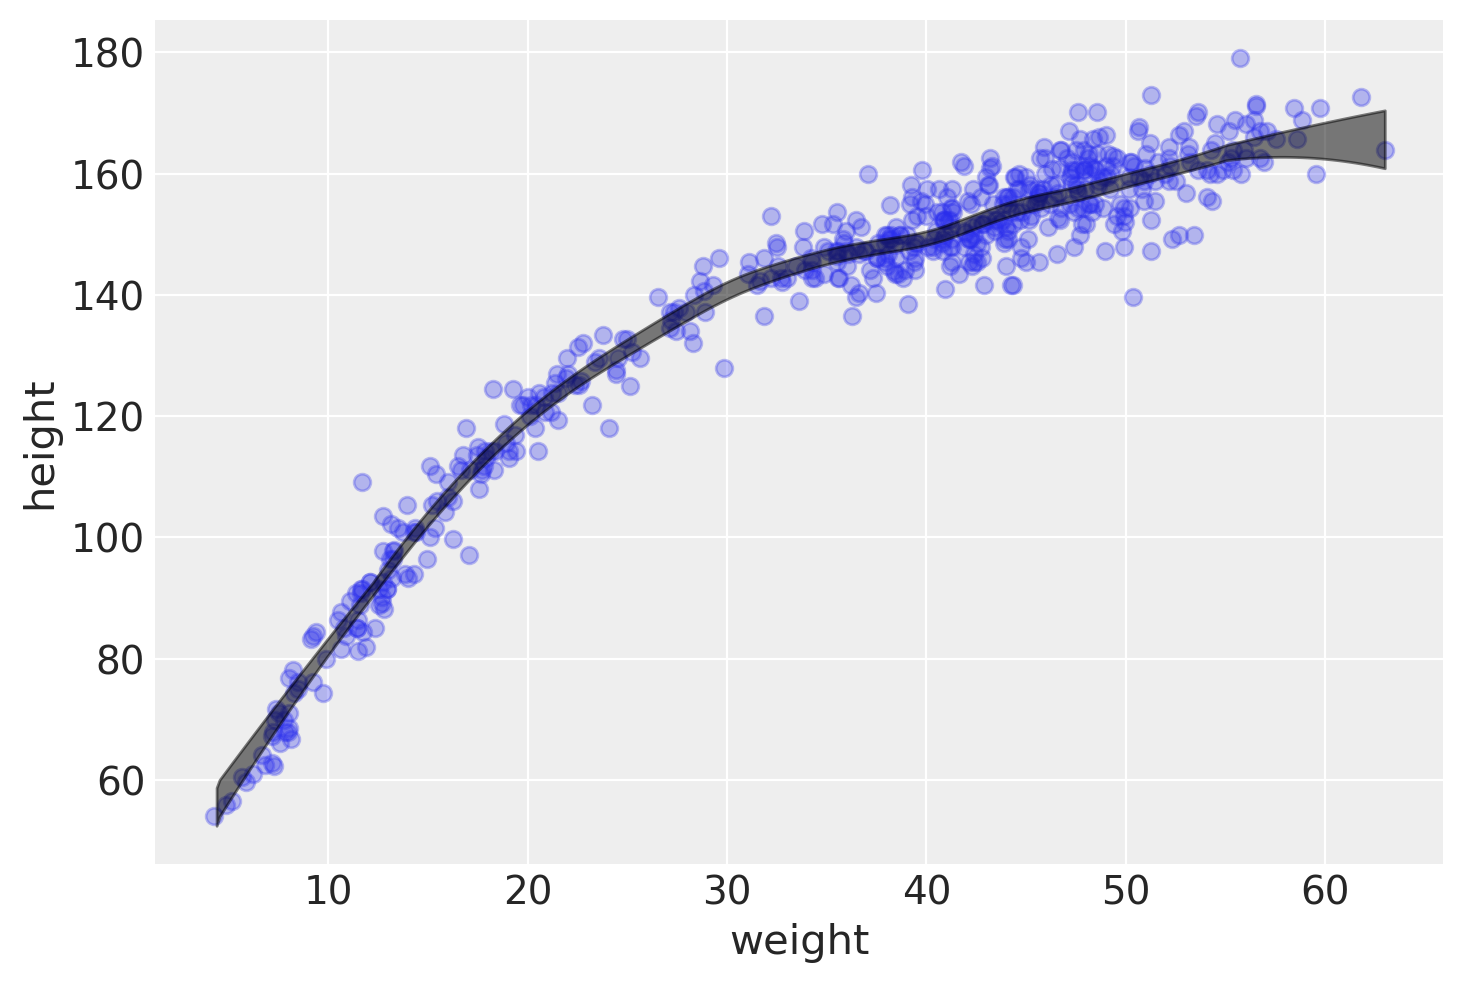

In [181]:
plt.scatter(height_df.weight, height_df.height, marker="o", alpha=.3)
ax = plt.gca()
az.plot_hpd(height_df.weight, bspline_height_trace['mu'], color='k', ax=ax)
ax.set_xlabel("weight")
ax.set_ylabel("height");